# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy
import pingouin as pg
from scipy.stats import shapiro
from scipy.stats import ttest_1samp
from scipy import stats
import pingouin as pg
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from typing import List, Union
import math
import seaborn as sns
import statsmodels.regression.linear_model as sm_l
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
import pandas as pd

import scipy
def return_binned_neuron_awake_sleep_rel(awake_dat,sleep_dat):
    awake_sleep_relationship = {}
    for index_, item, in enumerate(awake_dat):
        for index, awake_mouse_data in enumerate(item):

            awake = awake_mouse_data
            sleep = np.array(sleep_dat[index_][index])

            min_neurons_filter = 0
            bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]    

            for bin_ in bins:
                mask = np.round(awake,1) == bin_
                if len(sleep[mask]) > min_neurons_filter:
                    if bin_ in awake_sleep_relationship:
                        awake_sleep_relationship[bin_] += [np.mean(sleep[mask])]
                    else:
                        awake_sleep_relationship[bin_] = [np.mean(sleep[mask])]

    return awake_sleep_relationship




def plot_awake_sleep_relationship(awake_sleep_relationship,color_,ax):




    keys = []
    e_means = []
    sem = []
    for key in awake_sleep_relationship:
        if len(awake_sleep_relationship[key]) > 0:
            keys += [key]
    #         ax.plot([key]* len(e_awake_sleep_relationship[key]),e_awake_sleep_relationship[key],'o', color = 'red')

            a_s_relationship = [x for x in awake_sleep_relationship[key] if not np.isnan(x)]

            e_means += [np.mean(a_s_relationship)]
            sem += [scipy.stats.tstd(a_s_relationship)]
    ax.plot(sorted(keys),np.array(e_means)[np.argsort(keys)],'o--', c = color_, markersize = 10)

    upper = np.array(e_means)[np.argsort(keys)] + sem
    lower = np.array(e_means)[np.argsort(keys)] - sem
    ax.fill_between(sorted(keys),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)

    x = np.linspace(0, 1, 10)  # Example x values
    y = x  # Since x equals y, y values are the same as x values
    plt.plot(x,y,'--')


    ax.set_ylim(0,0.8)


    ax.set_ylabel('replay proportion involvement')
    ax.set_xlabel('awake proportion involvement')

    #################################################

    from scipy.optimize import curve_fit
    from scipy.stats import t

    # Extract the bins and corresponding values
    bins = list(awake_sleep_relationship.keys())
    
    bin_centers = np.array(bins)[np.argsort(bins)]
    values = np.array([np.nanmean(awake_sleep_relationship[bin]) for bin in bins])[np.argsort(bins)]

    # Define the exponential function
    def exponential_model(x, a, b):
        return a * np.exp(b * x)

    # Fit the model to the data
    popt, pcov = curve_fit(exponential_model, bin_centers, values)

    # Extract the fitting parameters
    a, b = popt

    # Calculate the fitted values
    fitted_values = exponential_model(bin_centers, *popt)

    # Calculate R-squared
    residuals = values - fitted_values
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((values - np.mean(values))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Degrees of freedom
    dof = max(0, len(bin_centers) - len(popt))

    # Calculate standard errors of the parameters
    perr = np.sqrt(np.diag(pcov))

    # Calculate t-values for the parameters
    t_values = popt / perr

    # Calculate p-values for the parameters
    p_values = [2 * (1 - t.cdf(np.abs(t_val), dof)) for t_val in t_values]

    print(f'Fitted parameters: a = {a}, b = {b}')
    print(f'R-squared: {r_squared}')
    print(f'p-values: {p_values}')

def manova_groups_neuron_involvement(data1,data2):

    nrem_means = []
    for key in data1:
        if len(data1[key]) > 0:
            nrem_means += [np.nanmean(data1[key])]
    rem_means = []       
    for key in data2:
        if len(data2[key]) > 0:
            rem_means += [np.nanmean(data2[key])]

    x = nrem_means
    y = sorted(data1)

    x2 = rem_means
    y2 = sorted(data2)

    import statsmodels.api as sm
    from statsmodels.multivariate.manova import MANOVA

    A = pd.DataFrame({'x': x,
                    'y': y,
                    'groups': ['A'] * len(x)})
    B = pd.DataFrame({'x': x2,
                    'y': y2,
                    'groups': ['B'] * len(x2)})
    # Combine the data into one DataFrame
    data = pd.concat([A, B], axis=0)


    # Perform MANOVA
    manova = MANOVA.from_formula('x + y ~ groups', data=data)

    # Print the MANOVA results
    print(manova.mv_test())
    
    return manova.mv_test()


def permanova_ordered_misordered(nrem, rem):

    df = pd.DataFrame(nrem + rem, columns=['ordered','misordered'])
    df['group'] = ['nrem']*len(nrem) + ['rem']*len(rem)

    # drop any NaNs
    df = df.dropna()

    # compute distance matrix
    dm = DistanceMatrix(
        squareform(pdist(df[['ordered','misordered']].values, 'euclidean'))
    )

    # run PERMANOVA
    res = permanova(dm, grouping=df['group'].tolist(), permutations=999)
    print(res)
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(df['group'].tolist())
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(df['group'].tolist())
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")


def plot_ordered_misrodered(nrem_ordered_misordered,var_string,var_string2):

    ordered = [item[0] for item in nrem_ordered_misordered]
    misordered = [item[1] for item in nrem_ordered_misordered]

    fig, ax = plt.subplots(figsize=(2, 5))

    ax.plot(np.zeros(len(ordered)), ordered, 'o', color = '#69BD45',alpha = 0.4)
    ax.boxplot([x for x in ordered if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))
    ax.plot(np.ones(len(misordered)), misordered, 'o', color = '#32495C',alpha = 0.4)
    ax.boxplot([x for x in misordered if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))

    ax.set_ylabel(var_string2)
    
    ax.set_title(var_string)
    
def cohens_d(x, y):
    """
    Compute Cohen's d for two independent samples.
    """
    x = np.array(x)
    y = np.array(y)
    nx = len(x)
    ny = len(y)
    # Pooled standard deviation
    pooled_std = np.sqrt(((nx-1)*x.std(ddof=1)**2 + (ny-1)*y.std(ddof=1)**2) / (nx + ny - 2))
    d = (x.mean() - y.mean()) / pooled_std
    return d

def permutation_test(list1, list2):
    # Define your test statistic function
    def test_statistic(list1, list2):
        return np.mean(list1) - np.mean(list2)

    # Compute the observed test statistic
    observed_statistic = test_statistic(list1, list2)

    # Combine the two lists
    combined_data = list1 + list2

    # Number of permutations
    num_permutations = 100000

    # Initialize an array to store the permuted test statistics
    permuted_statistics = np.zeros(num_permutations)

    # Permutation test
    for i in range(num_permutations):
        # Shuffle the combined data
        np.random.shuffle(combined_data)
        
        # Split the shuffled data back into two lists
        permuted_list1 = combined_data[:len(list1)]
        permuted_list2 = combined_data[len(list1):]
        
        # Compute the test statistic for the permuted data
        permuted_statistics[i] = test_statistic(permuted_list1, permuted_list2)

    # Calculate the p-value
    p_value = np.mean(permuted_statistics >= observed_statistic)


    plt.figure(figsize=(4, 3))
    plt.hist(permuted_statistics, bins=30, alpha=0.5, color='blue', edgecolor='black')
    plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')
    plt.xlabel('Test Statistic')
    plt.ylabel('Frequency')
    plt.title('Distribution of Permuted Test Statistics')
    plt.axvline(np.percentile(permuted_statistics, 97.5), color='green', linestyle='dashed', linewidth=2, label='95th Percentile')
    plt.axvline(np.percentile(permuted_statistics, 2.5), color='green', linestyle='dashed', linewidth=2)
    plt.axvline(np.percentile(permuted_statistics, 99), color='green', linestyle='dashed', linewidth=2, label='99th Percentile')
    plt.axvline(np.percentile(permuted_statistics, 1), color='green', linestyle='dashed', linewidth=2)
    plt.xlabel('Test Statistic')
    plt.legend()
    plt.grid(True)
    plt.show()
    

    print("- p-value:", p_value)
    print('- 99th percentile of permuted statistics:',np.percentile(permuted_statistics, 99))
    print("- Observed Test Statistic:", observed_statistic)

    

def plot_coactive_single(nrem_coactive_freqs_chunk, color_,var_string):   
    fig, ax= plt.subplots(1, 1,figsize=(3, 5))
    means = []
    stds = []
    x_ = []
    for item in nrem_coactive_freqs_chunk:
        ax.plot(np.ones(len(nrem_coactive_freqs_chunk[1]))*(1),nrem_coactive_freqs_chunk[1],'o', c = color_, alpha = 0.5, markeredgewidth = 0, markersize = 9)
        x_ += [item]
        means += [np.median(nrem_coactive_freqs_chunk[1])]
        stds += [np.std(nrem_coactive_freqs_chunk[1])]
        break 
    means = np.array(means)[np.argsort(x_)]
    stds = np.array(stds)[np.argsort(x_)]
    x_ = np.array(x_)[np.argsort(x_)]
    ax.plot(1.2,means[0],'<', color = color_,alpha = 0.7, markeredgewidth = 0, markersize = 9)
    ax.set_xlim(0,2)
    ax.set_ylabel('frequency')
    ax.set_title(var_string + ' coactive frequency')
    ax.set_ylim(0,1)


def plot_coactive_two_plus(nrem_coactive_freqs_chunk, color_,var_string): 
    max_keys = 6
    nrem_coactive_freqs_chunk = collapse_above_keys(nrem_coactive_freqs_chunk,max_keys)   

    fig, ax= plt.subplots(1, 1,figsize=(7, 5))
    means = []
    stds = []
    x_ = []
    for item in nrem_coactive_freqs_chunk:
        if not item == 1:
            ax.plot(np.ones(len(nrem_coactive_freqs_chunk[item]))*(item-0.1),nrem_coactive_freqs_chunk[item],'o', c = color_, alpha = 0.5, markeredgewidth = 0, markersize = 9)
            x_ += [item]
            means += [np.mean(nrem_coactive_freqs_chunk[item])]
            stds += [np.std(nrem_coactive_freqs_chunk[item])]
    means = np.array(means)[np.argsort(x_)]
    stds = np.array(stds)[np.argsort(x_)]
    x_ = np.array(x_)[np.argsort(x_)]

    ax.plot(x_,means,'<', color = color_,alpha = 0.7, markeredgewidth = 0, markersize = 8)
    ax.set_title(var_string + ' coactive frequency')
    ax.set_xlabel('number of coactive events')
    # SET THE X MARKERS 
    ax.set_xticks(np.arange(0, max_keys+2, 1))
    ax.set_xticklabels(['_','_','2','3','4','5','6+','_'])
    ax.set_ylim(0,0.8)
    
# get a reference to the original dict
def collapse_above_keys(freqs,max_key):

    # prepare a new dict and a placeholder for the merged value
    new_freqs = {}
    merged = []

    for k, v in freqs.items():
        if k < max_key:
            # keep all keys < max_key unchanged
            new_freqs[k] = v
        else:
            # collect everything with key >= max_key
            merged.append(v)

    # now combine the collected values into one entry "6+"
    # — if your values are numbers, you can sum them:
    if not len(merged) == 0:
        try:
            new_freqs[6] = sum(merged)
        except TypeError:
            # otherwise assume they’re sequences (lists, arrays…) and flatten:
            import itertools
            new_freqs[6] = list(itertools.chain.from_iterable(merged))

    # replace in your master dict
    return new_freqs

def permanova_coactive_freqs(dat1, dat2):
    df = pd.DataFrame()
    len1 = len(dat1[1])
    len2 = len(dat2[1])
    df['groups'] = ['control'] * len1 + ['lesion'] * len2

    for key in [1, 2, 3, 4, 5, 6]:
        arr1 = dat1.get(key, [0] * len1)
        arr2 = dat2.get(key, [0] * len2)

        # Normalize lengths
        if len(arr1) < len1:
            arr1 = arr1 + [0] * (len1 - len(arr1))
        elif len(arr1) > len1:
            arr1 = arr1[:len1]

        if len(arr2) < len2:
            arr2 = arr2 + [0] * (len2 - len(arr2))
        elif len(arr2) > len2:
            arr2 = arr2[:len2]

        df[str(key)] = arr1 + arr2

    # Now df is guaranteed consistent
    values = df[['1', '2', '3', '4', '5', '6']].values
    grouping = df['groups'].values

    pairwise_distances = pdist(values, metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    dm = DistanceMatrix(distance_matrix)

    results = permanova(dm, grouping, permutations=10000)
    print(results)

    # Compute effect size R²
    D = dm.data
    n = len(grouping)
    ss_total = np.sum(D**2) / n
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)
    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")

    return df





def extract_start_end_points(start_end_df):
    all_chunk_forward_start_mean = []
    all_chunk_forward_end_mean = []
    all_chunk_reverse_start_mean = []
    all_chunk_reverse_end_mean = []

    # s_o_d = []
    for mouse,group in start_end_df.groupby('mouse'):
        chunk_forward_start_mean = []
        chunk_forward_end_mean = []
        chunk_reverse_start_mean = []
        chunk_reverse_end_mean = []
        for diff, chunk in group.groupby('chunk_number'):
            forward_chunk = chunk[chunk.label == 'forward']
            chunk_forward_start_mean += [np.mean(forward_chunk[forward_chunk.group == 'starts']['distances (%)'].values)]
            chunk_forward_end_mean += [np.mean(forward_chunk[forward_chunk.group == 'ends']['distances (%)'].values)]

            reverse_chunk = chunk[chunk.label == 'reverse']
            chunk_reverse_start_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'starts']['distances (%)'].values)]
            chunk_reverse_end_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'ends']['distances (%)'].values)]

        all_chunk_forward_start_mean += [np.mean(chunk_forward_start_mean)]
        all_chunk_forward_end_mean += [np.mean(chunk_forward_end_mean)]
        all_chunk_reverse_start_mean += [np.mean(chunk_reverse_start_mean)]
        all_chunk_reverse_end_mean += [np.mean(chunk_reverse_end_mean)]
        
    return all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean


def plot_start_end_times(e_all_chunk_reverse_start_mean,e_all_chunk_forward_start_mean,e_all_chunk_reverse_end_mean,e_all_chunk_forward_end_mean,ax,ax2,var_str, color_):
        
    ## plot forward start and ends

    ax.plot(np.array(e_all_chunk_reverse_start_mean),np.ones(len(e_all_chunk_reverse_start_mean))*0.3,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)

    ax.plot(np.array(e_all_chunk_reverse_end_mean),np.ones(len(e_all_chunk_reverse_end_mean))*0.7,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)


    groups =  ['starts'] * len(e_all_chunk_reverse_start_mean) + (['ends'] * len(e_all_chunk_reverse_end_mean)) 
    data =  e_all_chunk_reverse_start_mean +e_all_chunk_reverse_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = color_, width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax)
        ax.set_xlabel('realtive start point')
        ax.set_title(var_str + '    reverse')

    ax.set_xlim(0,100)

    ###########

    ax2.plot(np.array(e_all_chunk_forward_start_mean),np.ones(len(e_all_chunk_forward_start_mean))*0.3,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)

    ax2.plot(np.array(e_all_chunk_forward_end_mean),np.ones(len(e_all_chunk_forward_end_mean))*0.7,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)


    groups =  ['starts'] * len(e_all_chunk_forward_start_mean) + (['ends'] * len(e_all_chunk_forward_end_mean)) 
    data =  e_all_chunk_forward_start_mean +e_all_chunk_forward_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = 'blue', width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax2)


        ax2.set_xlabel('realtive start point')
        ax2.set_title(var_str + '    forward')


    ax2.set_xlim(0,100)

# Function to compute partial eta-squared from Wilks' Lambda
def compute_partial_eta_squared(manova_results):
    eta_dict = {}
    for effect, stats in manova_results.results.items():
        # Use the current effect, not always 'group'
        wilks_lambda = stats['stat'].loc["Wilks' lambda", 'Value']
        eta_p2 = 1 - wilks_lambda
        eta_dict[effect] = eta_p2
    return eta_dict

# Define a type for nested lists of numbers
Nested = Union[float, List['Nested']]

def flatten(data: Nested) -> List[float]:
    """Recursively pull out all numeric values into a flat list."""
    if isinstance(data, list):
        vals = []
        for item in data:
            vals.extend(flatten(item))
        return vals
    else:
        return [data]

def compute_stats(flat_vals: List[float]) -> (float, float):
    """Return mean and standard deviation of a list of numbers."""
    n = len(flat_vals)
    mean = sum(flat_vals) / n
    var  = sum((x - mean)**2 for x in flat_vals) / n
    return mean, math.sqrt(var)

def zscoreize(data: Nested, mean: float, std: float) -> Nested:
    """
    Recursively replace each numeric entry by its z-score.
    Leaves the nesting structure intact.
    """
    if isinstance(data, list):
        return [zscoreize(item, mean, std) for item in data]
    else:
        return (data - mean) / std
    
def plot_decay(nrem_binned_rate,nrem_bins_relative_so,rem_binned_rate,rem_bins_relative_so,color_1, color_2, title_):
    fig,ax = plt.subplots(1, 1,figsize=(7, 5))
    AA_rate = []
    AA_post_so_time = []
    times = []
    rates = []
    for i,item in enumerate(nrem_binned_rate):
        across_chunks_x = []
        across_chunks_y = []
        for e,chunk_item in enumerate(item):
            #mean for each time series across chunks
            across_chunks_x += [np.mean(nrem_bins_relative_so[i][e])]
            across_chunks_y += [np.mean(chunk_item)]
        AA_rate+=[across_chunks_y]
        AA_post_so_time+=[across_chunks_x]
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = color_1, alpha = 1, markersize = 10, markeredgewidth = 0)
        # save out stuff for plot 2
        rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
        times += across_chunks_y[0:-1]
        rates += list(rate_change_per_min)
        
    AA_rate = []
    AA_post_so_time = []
    times_2 = []
    rates_2 = []
    for i,item in enumerate(rem_binned_rate):
        across_chunks_x = []
        across_chunks_y = []
        for e,chunk_item in enumerate(item):
            #mean for each time series across chunks
            across_chunks_x += [np.mean(rem_bins_relative_so[i][e])]
            across_chunks_y += [np.mean(chunk_item)]
        AA_rate+=[across_chunks_y]
        AA_post_so_time+=[across_chunks_x]
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = color_2, alpha = 1, markersize = 10, markeredgewidth = 0)
        # save out stuff for plot 2
        rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
        times_2 += across_chunks_y[0:-1]
        rates_2 += list(rate_change_per_min)
        
    ax.set_title(title_)
    ax.set_xlabel('time after sleep onset (mins)')
    
    fig,ax = plt.subplots(1, 1,figsize=(5, 5))                
    sns.regplot(x=times, y=rates, ax = ax, color = color_1,scatter_kws={'s': 160, 'alpha': 0.3,'linewidths': 0})
    sns.regplot(x=times_2, y=rates_2, ax = ax, color = color_2,scatter_kws={'s': 160, 'alpha': 0.3,'linewidths': 0})
    ax.set_xlabel('starting rate')
    ax.set_ylabel('rate change per minute')
    ax.axhline(0,0,ls ='--')
    
    group1_data = {'x': times, 'y': rates}
    group2_data = {'x': times_2, 'y': rates_2}
    return group1_data, group2_data

def permanova_forward_vs_reverse(f_warp_factors, r_warp_factors):
    grouping = ['control_forwards']*len(np.vstack(f_warp_factors)) + ['control_reverse']*len(np.vstack(r_warp_factors))

    pairwise_distances = pdist(np.asarray(f_warp_factors+r_warp_factors), metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    dm = DistanceMatrix(distance_matrix)

    # Perform PERMANOVA
    results = permanova(dm, grouping, permutations=10000)
    print(results)
    
    #Compute R² manually (effect size)
    # ss_total = sum of squared distances / n
    D = dm.data        # <-- this is the fix
    n = len(grouping)
    ss_total = np.sum(D**2) / n

    # ss_between: sum of squared group means
    group_labels = np.array(grouping)
    unique_groups = np.unique(group_labels)
    ss_between = 0
    for g in unique_groups:
        idx = np.where(group_labels == g)[0]
        Di = D[np.ix_(idx, idx)]
        ss_between += len(idx) * (Di.mean() ** 2)

    r2 = ss_between / ss_total
    print(f"PERMANOVA effect size R²: {r2:.5f}")

def effect_size(x=None, y=None, test='ttest', dv=None, between=None, data=None,
                dm=None, grouping=None, popmean=None, permutations=999):
    """
    Calculate effect sizes for parametric, non-parametric, regression, and PERMANOVA.

    Parameters
    ----------
    x : array-like
        First sample (or single sample for one-sample t-test)
    y : array-like, optional
        Second sample (if applicable)
    test : str
        One of ['ttest', 'paired_ttest', 'one_sample_ttest', 'anova',
                'mannwhitney', 'wilcoxon', 'kruskal', 'correlation', 'permanova']
    dv, between, data : for ANOVA/Kruskal (pingouin syntax)
    dm : DistanceMatrix for PERMANOVA
    grouping : array-like of group labels for PERMANOVA
    popmean : population mean for one-sample t-test
    permutations : number of permutations for PERMANOVA
    """
    # Convert to numpy arrays if needed
    x = np.array(x) if x is not None else None
    y = np.array(y) if y is not None else None

    if test == 'ttest':  # independent
        t, p = stats.ttest_ind(x, y)
        pooled_std = np.sqrt(((len(x)-1)*x.std(ddof=1)**2 + (len(y)-1)*y.std(ddof=1)**2) / (len(x)+len(y)-2))
        d = (x.mean() - y.mean()) / pooled_std
        return {"cohens_d": d}

    elif test == 'paired_ttest':
        t, p = stats.ttest_rel(x, y)
        d = (x - y).mean() / (x - y).std(ddof=1)
        return {"cohens_d": d}

    elif test == 'one_sample_ttest':
        if popmean is None:
            raise ValueError("popmean must be provided for one-sample t-test")
        t, p = stats.ttest_1samp(x, popmean)
        d = (np.nanmean(x) - popmean) / x.std(ddof=1)
        return {"cohens_d": d}

    elif test == 'anova':
        res = pg.anova(dv=dv, between=between, data=data, detailed=True)
        return res[['Source', 'F', 'p-unc', 'eta-square', 'partial_eta-square']]

    elif test == 'mannwhitney':
        res = pg.mwu(x, y, alternative='two-sided', effsize='r')
        return {"test": "Mann-Whitney U", "U": res['U-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}

    elif test == 'wilcoxon':
        res = pg.wilcoxon(x, y, alternative='two-sided')
        return {"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}

    elif test == 'kruskal':
        res = pg.kruskal(data=data, dv=dv, between=between)
        return res[['H', 'p-unc', 'eta-square', 'eps-square']]

    elif test == 'correlation':
        r, p = stats.pearsonr(x, y)
        return {"test": "Pearson correlation", "r": r, "p": p}

    else:
        raise ValueError(f"Unsupported test type: {test}")


def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

# figure C

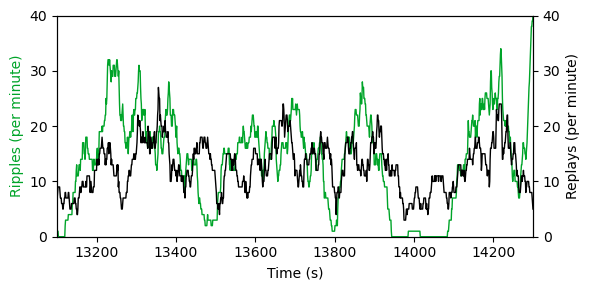

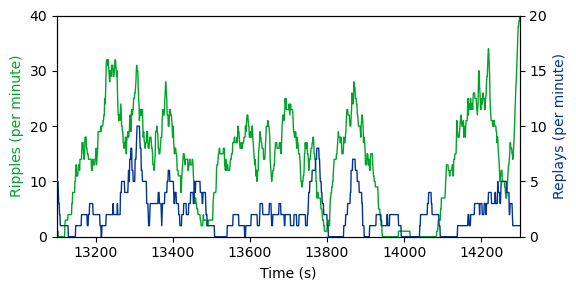

In [ ]:
data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED12\ripple_spindle_replay_rates.npz", allow_pickle=True)

bin_centers= data['bin_centers'] 
ripple_rate= data['ripple_rate'] 
replay_rate = data['replay_rate']
spindle_rate= data['spindle_rate'] 

fig, ax1 = plt.subplots(figsize=(6, 3))

# First axis: Ripples
ax1.plot(
    bin_centers,
    convolve_movmean(ripple_rate, 30),
    label="Ripples per min",
    lw=1,
    color = "#00A429"
)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ripples (per minute)", color = "#00A429")
ax1.set_ylim(0,40)

# Second axis: Replays
ax2 = ax1.twinx()
ax2.plot(
    bin_centers,
    convolve_movmean(replay_rate, 30),
    label="Replays per min",
    lw=1,
    color = "#000000"
)
ax2.set_ylabel("Replays (per minute)", color = "#000000")
ax2.set_ylim(0,40)

ax1.set_xlim(13100,bin_centers[-1])

plt.tight_layout()
plt.show()

######## PLOT 2

fig, ax1 = plt.subplots(figsize=(6, 3))

# First axis: Ripples
ax1.plot(
    bin_centers,
    convolve_movmean(ripple_rate, 30),
    label="spindle rate per min",
    lw=1,
    color = "#00A429"
)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ripples (per minute)", color = "#00A429")
ax1.set_ylim(0,40)

# Second axis: Replays
ax2 = ax1.twinx()
ax2.plot(
    bin_centers,
    convolve_movmean(spindle_rate, 30),
    label="Replays per min",
    lw=1,
    color = "#003590"
)
ax2.set_ylabel("Replays (per minute)", color = "#003590")
ax2.set_ylim(0,20)

ax1.set_xlim(13100,bin_centers[-1])


plt.tight_layout()
plt.show()



# figure D

(-20.0, 20.0)

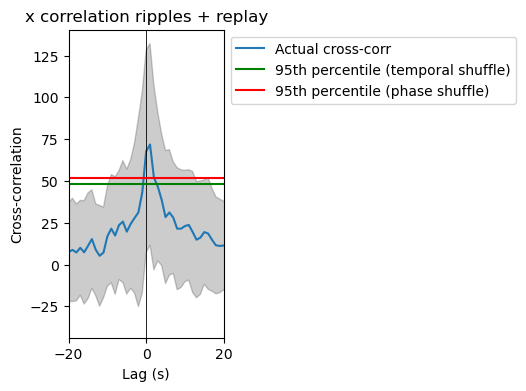

In [3]:


data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED12\ripple_replay_xcorr_plot_data.npz", allow_pickle=True)

mean_x = data["mean_x"]
mean_y = data["mean_y"]
st_dev = data["st_dev"]

mean_y_shuf = data["mean_y_shuf"]
mean_y_shuf_2 = data["mean_y_shuf_2"]


plt.figure(figsize=(2,4))
plt.fill_between(mean_x, convolve_movmean(mean_y,2) - st_dev, convolve_movmean(mean_y,2) + st_dev, alpha=0.2, color='k')
plt.plot(mean_x, convolve_movmean(mean_y,2), label='Actual cross-corr')
plt.axvline(0, color='k', linewidth=0.6)
plt.axhline(np.percentile(mean_y_shuf,95),color = 'green',label='95th percentile (temporal shuffle)')
plt.axhline(np.percentile(mean_y_shuf_2,95),color = 'red',label='95th percentile (phase shuffle)')
plt.xlabel('Lag (s)')            # or 'Lag (ms)' if you multiply by 1000
plt.ylabel('Cross-correlation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('x correlation ripples + replay')
plt.xlim(-20,20)


# figure E

(-20.0, 20.0)

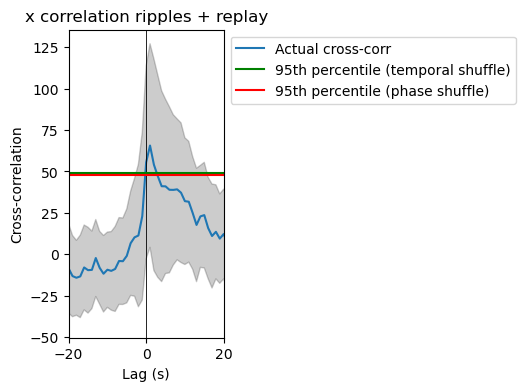

In [4]:


data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED12\spindle_replay_xcorr_plot_data.npz", allow_pickle=True)

mean_x = data["mean_x"]
mean_y = data["mean_y"]
st_dev = data["st_dev"]

mean_y_shuf = data["mean_y_shuf"]
mean_y_shuf_2 = data["mean_y_shuf_2"]


plt.figure(figsize=(2,4))
plt.fill_between(mean_x, convolve_movmean(mean_y,2) - st_dev, convolve_movmean(mean_y,2) + st_dev, alpha=0.2, color='k')
plt.plot(mean_x, convolve_movmean(mean_y,2), label='Actual cross-corr')
plt.axvline(0, color='k', linewidth=0.6)
plt.axhline(np.percentile(mean_y_shuf,95),color = 'green',label='95th percentile (temporal shuffle)')
plt.axhline(np.percentile(mean_y_shuf_2,95),color = 'red',label='95th percentile (phase shuffle)')
plt.xlabel('Lag (s)')            # or 'Lag (ms)' if you multiply by 1000
plt.ylabel('Cross-correlation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('x correlation ripples + replay')
plt.xlim(-20,20)


# figure G

In [12]:
data = np.load(r"C:\Users\Emmett Thompson\Documents\procedural_replay_paper_2025\data\ED12\ripple_replay_linkage_hist_plot_data.npz", allow_pickle=True)

bins = data["bins"]
bin_centres = data["bin_centres"]

mean_all_z_data = data["mean_all_z_data"]
std_all_z_data = data["std_all_z_data"]

all_rand_ripples_z_data = data["all_rand_ripples_z_data"]
all_rand_replay_z_data = data["all_rand_replay_z_data"]


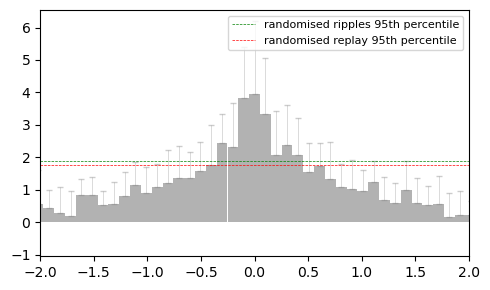

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Bin widths
widths = np.diff(bins)

# Error bar style
error_style = dict(
    ecolor="grey",
    elinewidth=0.5,
    capsize=2,
    alpha=0.4
)

# Main bar plot
ax.bar(
    bin_centres,
    mean_all_z_data,
    width=widths,
    yerr=[np.zeros_like(std_all_z_data), std_all_z_data],
    align="center",
    alpha=0.6,
    color="grey",
    error_kw=error_style
)

# 95th percentile thresholds
ripples_95 = np.percentile(
    np.mean(all_rand_ripples_z_data, axis=0),
    95
)

replay_95 = np.percentile(
    np.mean(all_rand_replay_z_data, axis=0),
    95
)

ax.axhline(
    ripples_95,
    color="green",
    lw=0.5,
    ls="--",
    label="randomised ripples 95th percentile"
)

ax.axhline(
    replay_95,
    color="red",
    lw=0.5,
    ls="--",
    label="randomised replay 95th percentile"
)

# Formatting
ax.set_xlim(-2, 2)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


# figure H

Text(0.5, 1.0, 'percentage of replay linked to SW-R')

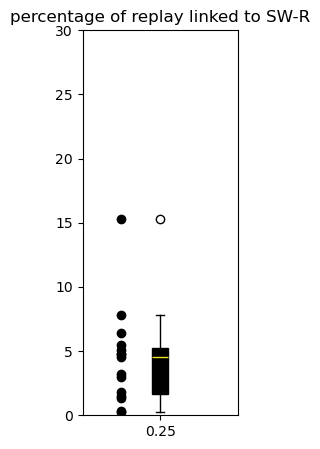

In [7]:
all_prop_replay_linked_to_SWR= [0.05485232067510549,
 0.06429780033840947,
 0.047400611620795105,
 0.0024410089503661514,
 0.01366742596810934,
 0.04520625353173856,
 0.029792746113989636,
 0.050518568082970894,
 0.015184381778741865,
 0.15330739299610896,
 0.018207282913165267,
 0.031914893617021274,
 0.0036429872495446266,
 0.047787610619469026,
 0.07777777777777778]

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(all_prop_replay_linked_to_SWR)), np.array(all_prop_replay_linked_to_SWR)*100, 'o', color = 'k')
ax.boxplot(np.array(all_prop_replay_linked_to_SWR)*100, positions=[0.25], widths=0.1, patch_artist=True, boxprops=dict(facecolor='k', color='k'), medianprops=dict(color='#EAE324'))
ax.set_ylim(0,30)
ax.set_title('percentage of replay linked to SW-R')

# figure I

Text(0.5, 1.0, 'percentage of SW-R linked to replay')

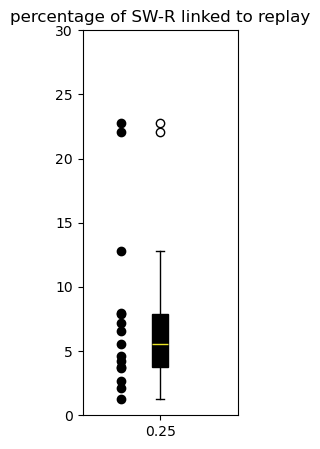

In [10]:
all_proportion_SWR_linked_to_replay = [0.07907542579075426,
 0.06595905989385899,
 0.046370967741935484,
 0.04225352112676056,
 0.22093023255813954,
 0.22737556561085973,
 0.03787878787878788,
 0.07941834451901567,
 0.026845637583892617,
 0.0721331689272503,
 0.012658227848101266,
 0.05537459283387622,
 0.021052631578947368,
 0.12762520193861066,
 0.03685092127303183]

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(all_proportion_SWR_linked_to_replay)), np.array(all_proportion_SWR_linked_to_replay)*100, 'o', color = 'k')
ax.boxplot(np.array(all_proportion_SWR_linked_to_replay)*100, positions=[0.25], widths=0.1, patch_artist=True, boxprops=dict(facecolor='k', color='k'), medianprops=dict(color='#EAE324'))
ax.set_ylim(0,30)
ax.set_title('percentage of SW-R linked to replay')


# figure J

In [53]:


in_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\hippocampus_lfp\\"

with open(in_path + "LINKED_UNLIKNED_processed_replay_data.pkl", 'rb') as f:
    linked_unlinked_master = pickle.load(f)
    
with open(in_path + "awake_seqbyseq_neuron_involvements.pkl", 'rb') as f:
    neuron_involvement_master = pickle.load(f)
    

-------------------
ShapiroResult(statistic=np.float64(0.8526833767818593), pvalue=np.float64(0.014924636965775477))
ShapiroResult(statistic=np.float64(0.9537153753161683), pvalue=np.float64(0.5178548726021497))
WilcoxonResult(statistic=np.float64(44.0), pvalue=np.float64(0.231201171875))
{'test': 'Wilcoxon signed-rank', 'W': np.float64(44.0), 'p': np.float64(0.231201171875), 'rank_biserial_r': np.float64(-0.35294117647058826)}
------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_54944\1358901133.py:4: RuntimeWarning: Mean of empty slice
  linked_event_lens = [np.nanmean(item) for item in linked_event_lens]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_54944\1358901133.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print({"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]})


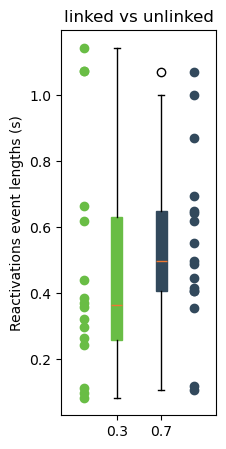

In [60]:
linked_event_lens = linked_unlinked_master['linked']['event_lens']
unlinked_event_lens = linked_unlinked_master['unlinked']['event_lens']

linked_event_lens = [np.nanmean(item) for item in linked_event_lens]
unlinked_event_lens = [np.nanmean(item) for item in unlinked_event_lens]

##############################################

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(linked_event_lens)), linked_event_lens, 'o', color = '#69BD45')
ax.boxplot([x for x in linked_event_lens if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))

ax.plot(np.ones(len(unlinked_event_lens)), unlinked_event_lens, 'o', color = '#32495C')
ax.boxplot([x for x in unlinked_event_lens if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))

ax.set_ylabel('Reactivations event lengths (s)')

ax.set_title('linked vs unlinked')

print('-------------------')

a = [x for x in linked_event_lens if not np.isnan(x)]
b = [x for x in unlinked_event_lens if not np.isnan(x)]

print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
# p is greater than 0.05 for both, so we fail to reject the null hypothesis that the data is normally distributed
# print(scipy.stats.ttest_ind(a,b))
# non parametric t test, using scipy Wilcoxon Rank-Sum test
print(scipy.stats.wilcoxon(linked_event_lens, unlinked_event_lens,nan_policy='omit'))

res = pg.wilcoxon(linked_event_lens, unlinked_event_lens, alternative='two-sided', nan_policy="omit")
print({"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]})
print('------------')

# figure K 

In [64]:
import scipy
import pandas as pd 

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def find_closest_example(numbers, examples):
    # Initialize dictionaries to store the closest example and example totals
    closest_examples = {}
    example_totals = {example: 0 for example in examples}

    # Iterate over each number in the list
    for number in numbers:
        # Initialize a variable to keep track of the closest example
        closest_example = None
        min_distance = float('inf')  # Initialize the minimum distance to infinity

        # Compare the number with each example
        for example in examples:
            # Calculate the absolute difference between the number and example
            distance = abs(number - example)

            # Check if the current example is closer than the previous closest example
            if distance < min_distance:
                min_distance = distance
                closest_example = example

        # Update the closest example for the current number in the dictionary
        closest_examples[number] = closest_example

        # Increment the total count for the closest example
        example_totals[closest_example] += 1

    return closest_examples, example_totals

def relative_warp_values(e_f_warp_factors):
    rels = []
    for item in e_f_warp_factors:
        if sum(item) > 0:
            # normalize the warp factors to sum to 1
            rels += [list(np.array(item)/sum(item))]
    return rels



bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]

def extract_mean_warps(regression_df, bins_,animals_list):

    f_warp_factors = []
    r_warp_factors = []

    forward = []
    reverse = []
    
    forward_total = []
    reverse_total = []

    for mouse in animals_list:
        mask = regression_df.mouse == mouse
        group = regression_df[mask]
        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        forward_total += [len(data)]
        closest_examples,example_totals = find_closest_example(data,bins_)
        f_warp_factors +=[list(example_totals.values())]
        forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        reverse_total += [len(data)]
        closest_examples,example_totals = find_closest_example(data,bins_)
        r_warp_factors +=[list(example_totals.values())]
        reverse += [sum(example_totals.values())]


            
    f_warp_factors = relative_warp_values(f_warp_factors)
    r_warp_factors = relative_warp_values(r_warp_factors)
    
    return f_warp_factors, r_warp_factors, forward_total, reverse_total

def plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_):

    bin_labels = [item + 'x' for item in np.array(bins_).astype(str)]

    means = []
    sems = []
    for item in conactinate_nth_items(f_warp_factors):
        means += [np.mean(item)]
        sems += [scipy.stats.sem(item)]
    ax.plot(means,'-->', color = color_, markersize = 8, label = 'forward')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)

    means = []
    sems = []
    for item in conactinate_nth_items(r_warp_factors):
        means += [np.mean(item)]
        sems += [scipy.stats.sem(item)]
    ax.plot(means,'--<', color = color_, markersize = 8,label = 'reverse')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)


In [76]:
linked_forward_total

[30, 1, 5, 9, 11, 46, 4, 66, 14, 24, 1, 0, 3, 1, 0, 2, 0]

In [77]:
linked_reverse_total

[11, 7, 2, 6, 7, 25, 3, 27, 11, 3, 0, 0, 0, 1, 0, 4, 2]

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_54944\3775851871.py:9: RuntimeWarning: divide by zero encountered in divide
  linked_proportion_forward_v_reverse = np.array(linked_forward_total)/np.array(linked_reverse_total)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_54944\3775851871.py:9: RuntimeWarning: invalid value encountered in divide
  linked_proportion_forward_v_reverse = np.array(linked_forward_total)/np.array(linked_reverse_total)


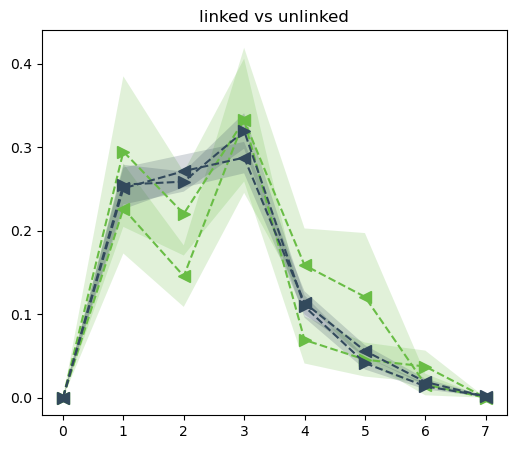

ShapiroResult(statistic=np.float64(0.6501603348748944), pvalue=np.float64(5.854544735932819e-15))
ShapiroResult(statistic=np.float64(0.6681953674656478), pvalue=np.float64(5.338123997694171e-14))
ShapiroResult(statistic=np.float64(0.8458340389026514), pvalue=np.float64(1.2881875455403877e-10))
ShapiroResult(statistic=np.float64(0.8626454165000563), pvalue=np.float64(6.725337037971675e-10))
 all are not normally distributed, so we will use a non-parametric test
-------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      27
number of groups                  2
test statistic             0.652919
p-value                    0.606739
number of permutations        10000
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.73695
-------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      34
number of groups                  2
test statistic            

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_54944\1227824181.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"test": "Wilcoxon signed-rank", "W": res['W-val'][0], "p": res['p-val'][0], "rank_biserial_r": res['RBC'][0]}


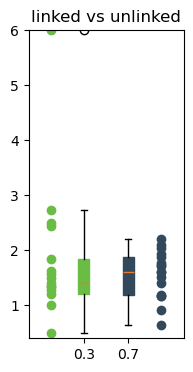

In [91]:
bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]
animals_list = linked_unlinked_master['linked']['animals']



###############################################################

linked_f_warp_factors, linked_r_warp_factors, linked_forward_total, linked_reverse_total = extract_mean_warps(pd.DataFrame(linked_unlinked_master['linked']['regression']), bins_,animals_list)
linked_proportion_forward_v_reverse = np.array(linked_forward_total)/np.array(linked_reverse_total)
linked_proportion_forward_v_reverse = np.array([2.72727273, 0.14285714, 2.5       , 1.5       , 1.57142857,
       1.84      , 1.33333333, 2.44444444, 1.27272727, 6.        ,
              1.35,        1.4,        1.62, 1.        ,        1.2,
       0.5       , 0.        ])

unlinked_f_warp_factors, unlinked_r_warp_factors, unlinked_forward_total, unlinked_reverse_total = extract_mean_warps(pd.DataFrame(linked_unlinked_master['unlinked']['regression']), bins_,animals_list)
unlinked_proportion_forward_v_reverse = np.array(unlinked_forward_total)/np.array(unlinked_reverse_total)

###############################################################

fig,ax = plt.subplots(1, 1,figsize=(6, 5))
color_ = '#69BD45'
plot_warp_factors(ax, linked_f_warp_factors, linked_r_warp_factors, bins_, color_)
color_ = '#32495C'
plot_warp_factors(ax, unlinked_f_warp_factors, unlinked_r_warp_factors, bins_, color_)
ax.set_title('linked vs unlinked')

plt.show()
## STATS
print(scipy.stats.shapiro([item for sublist in linked_f_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in linked_r_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in unlinked_f_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in unlinked_r_warp_factors for item in sublist]))
print(' all are not normally distributed, so we will use a non-parametric test')
    
print('-------------------')
permanova_forward_vs_reverse(linked_f_warp_factors, linked_r_warp_factors)
print('-------------------')
permanova_forward_vs_reverse(unlinked_f_warp_factors, unlinked_r_warp_factors)

######## INSET

fig, ax = plt.subplots(figsize=(2, 4))
ax.plot(np.zeros(len(linked_proportion_forward_v_reverse)),linked_proportion_forward_v_reverse,'o', color = '#69BD45')
ax.boxplot([x for x in linked_proportion_forward_v_reverse if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))
ax.plot(np.ones(len(unlinked_proportion_forward_v_reverse)),unlinked_proportion_forward_v_reverse,'o', color = '#32495C')
ax.boxplot([x for x in unlinked_proportion_forward_v_reverse if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))
ax.set_title('linked vs unlinked')
ax.set_ylim(0.4,6)

########## STATS
print('--------------------')
# Perform one-sample t-test
statistic, p_value = ttest_1samp(linked_proportion_forward_v_reverse, 1.0)
# Print the test statistic and p-value
print("Test statistic:", statistic)
print("P-value:", p_value)
print(effect_size(x=linked_proportion_forward_v_reverse,test='one_sample_ttest',popmean = 1))

print('--------------------')
# Perform one-sample t-test
statistic, p_value = ttest_1samp(unlinked_proportion_forward_v_reverse, 1.0, nan_policy="omit")
# Print the test statistic and p-value
print("Test statistic:", statistic)
print("P-value:", p_value)
print(effect_size(x=unlinked_proportion_forward_v_reverse,test='one_sample_ttest',popmean = 1))


print(scipy.stats.shapiro(linked_proportion_forward_v_reverse))
print(scipy.stats.shapiro(unlinked_proportion_forward_v_reverse))

## not all normal so use wilcoxn signed rank
# print(scipy.stats.wilcoxon(nrem_proportion_forward_v_reverse, rem_proportion_forward_v_reverse,nan_policy='omit'))
# print(effect_size(x=nrem_proportion_forward_v_reverse, y=rem_proportion_forward_v_reverse, test='wilcoxon'))
print('------------------------------------------')
print(scipy.stats.wilcoxon(linked_proportion_forward_v_reverse, unlinked_proportion_forward_v_reverse, nan_policy='omit'))
print(effect_size(x=linked_proportion_forward_v_reverse, y=unlinked_proportion_forward_v_reverse, test='wilcoxon'))

# figure L

PLOT 2:
Group 1 (NREM):
model p value (f statistic) = 
5.1080692324608326e-05
r2 = 
0.7018370814363191
Group 2 (REM):
model p value (f statistic) = 
4.3731726584587205e-13
r2 = 
0.8713375311222806
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     32.95
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           5.11e-05
Time:                        16:42:00   Log-Likelihood:                 61.546
No. Observations:                  16   AIC:                            -119.1
Df Residuals:                      14   BIC:                            -117.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
             

c:\miniconda\envs\proc_replay_2025\lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


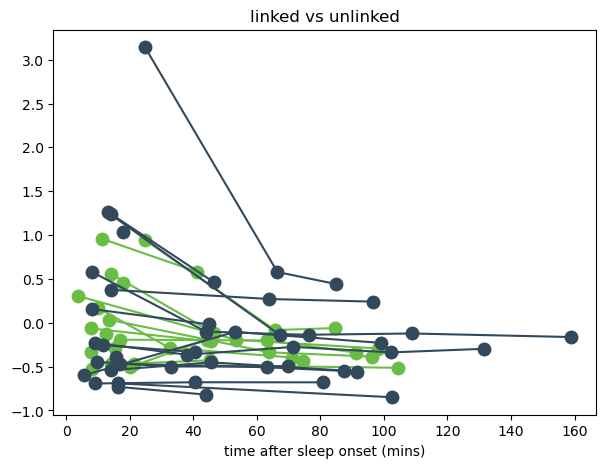

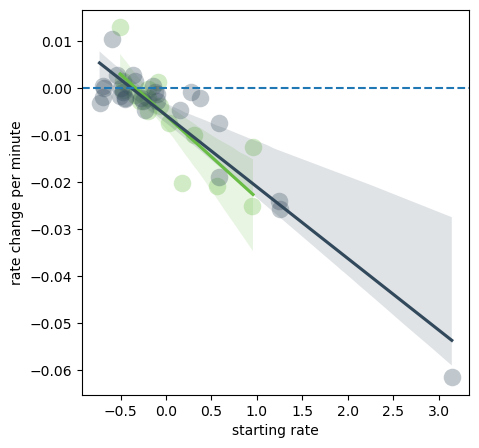

In [ ]:
# 1. Flatten
flat = flatten(linked_unlinked_master['linked']['binned_rate'])
# 2. Compute mean & std
mean = np.nanmean(flat)
std = np.nanstd(flat)
# 3. Recurse to z-score
normalized_linked = zscoreize(linked_unlinked_master['linked']['binned_rate'], mean, std)


# 1. Flatten
flat = flatten(linked_unlinked_master['unlinked']['binned_rate'])
# 2. Compute mean & std
mean = np.nanmean(flat)
std = np.nanstd(flat)
# 3. Recurse to z-score
normalized_unlinked = zscoreize(linked_unlinked_master['unlinked']['binned_rate'], mean, std)


group1_data, group2_data = plot_decay(normalized_linked  ,linked_unlinked_master['linked']['bins_relative_so'],normalized_unlinked ,linked_unlinked_master['unlinked']['bins_relative_so'], '#69BD45','#32495C','linked vs unlinked')


###################### STATS
df1 = pd.DataFrame(group1_data)
df2 = pd.DataFrame(group2_data)
# Fit linear regression for Group 1
model_group1 = sm_l.OLS.from_formula('y ~ x', data=df1).fit()
model_group2 = sm_l.OLS.from_formula('y ~ x', data=df2).fit()

print('PLOT 2:')
# Print the summary of each model
print("Group 1 (NREM):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group1.f_pvalue)
print('r2 = ')
print(model_group1.rsquared)

print("Group 2 (REM):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group2.f_pvalue)
print('r2 = ')
print(model_group2.rsquared)


### STATS
### effect of decay - significance
# Add a constant term to the independent variable
data = sm.add_constant(df1)
# Fit the regression model
model = sm.OLS(data['y'], data[['const', 'x']],missing='drop').fit()
# Print the summary statistics
print(model.summary())
r = np.sign(model.params['x']) * np.sqrt(model.rsquared)
print(r)
print(model.rsquared)
print(model.pvalues['x'])

data = sm.add_constant(df2)
# Fit the regression model
model = sm.OLS(data['y'], data[['const', 'x']],missing='drop').fit()
# Print the summary statistics
print(model.summary())
r = np.sign(model.params['x']) * np.sqrt(model.rsquared)
print(r)
print(model.rsquared)
print(model.pvalues['x'])

# Combine the data into one DataFrame
data = pd.concat([df1, df2], axis=0)

# Create a grouping variable
groups = np.array(['nrem'] * len(df1) + ['rem'] * len(df2))

# Perform MANOVA
manova = MANOVA.from_formula('x + y ~ groups', data=data)

# Print the MANOVA results
print(manova.mv_test())

# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(manova.mv_test())
print("Partial eta-squared for each effect:", eta_squared)

# figure M

c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\envs\proc_replay_2025\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ShapiroResult(statistic=np.float64(0.9034944205189074), pvalue=np.float64(0.17596731336185))
ShapiroResult(statistic=np.float64(0.9261204799690287), pvalue=np.float64(0.3729504250022314))
ShapiroResult(statistic=np.float64(0.8811448737889472), pvalue=np.float64(0.09065815760136146))
ShapiroResult(statistic=np.float64(0.9018137842964645), pvalue=np.float64(0.19450107683666384))
ShapiroResult(statistic=np.float64(0.9599918367002463), pvalue=np.float64(0.6313269155839818))
ShapiroResult(statistic=np.float64(0.952572310514162), pvalue=np.float64(0.4984523235426101))
ShapiroResult(statistic=np.float64(0.9769238610165648), pvalue=np.float64(0.9240305240741548))
ShapiroResult(statistic=np.float64(0.9395429982119354), pvalue=np.float64(0.312806627585959))
_____________________________________________________________________________________________
                  Multivariate linear model
                                                              
-----------------------------------------

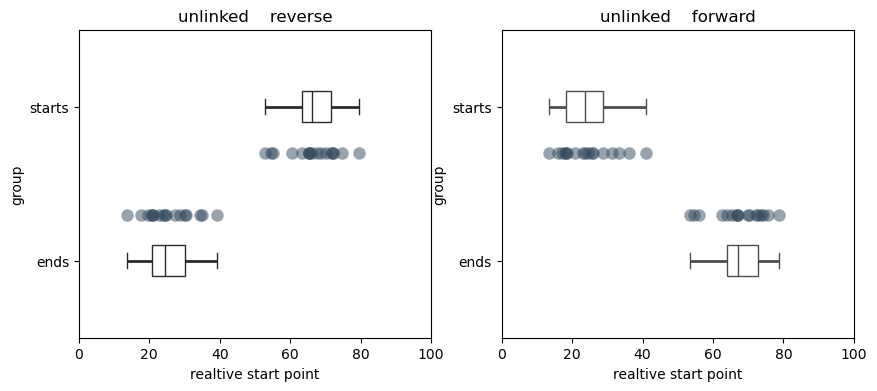

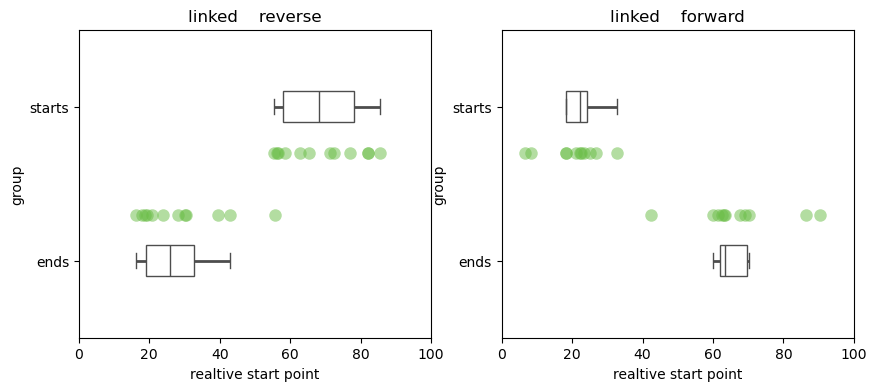

In [111]:

fig,[ax,ax2] = plt.subplots(1, 2,figsize=(10, 4))
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(linked_unlinked_master['unlinked']['start_end']))
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'unlinked','#32495C')

fig,[ax,ax2] = plt.subplots(1, 2,figsize=(10, 4))
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(linked_unlinked_master['linked']['start_end']))
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'linked','#69BD45')



linked_all_chunk_reverse_start_mean, linked_all_chunk_forward_start_mean, linked_all_chunk_reverse_end_mean, linked_all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(linked_unlinked_master['linked']['start_end']))
unlinked_all_chunk_reverse_start_mean, unlinked_all_chunk_forward_start_mean, unlinked_all_chunk_reverse_end_mean, unlinked_all_chunk_forward_end_mean = extract_start_end_points(pd.DataFrame(linked_unlinked_master['unlinked']['start_end']))

group1 = [x for x in linked_all_chunk_reverse_start_mean if not np.isnan(x)] 
group2 = [x for x in linked_all_chunk_forward_start_mean if not np.isnan(x)] 
group3 = [x for x in linked_all_chunk_reverse_end_mean if not np.isnan(x)] 
group4 = [x for x in linked_all_chunk_forward_end_mean if not np.isnan(x)] 
group5 = [x for x in unlinked_all_chunk_reverse_start_mean if not np.isnan(x)] 
group6 = [x for x in unlinked_all_chunk_forward_start_mean if not np.isnan(x)] 
group7 = [x for x in unlinked_all_chunk_reverse_end_mean if not np.isnan(x)] 
group8 = [x for x in unlinked_all_chunk_forward_end_mean if not np.isnan(x)] 

for group in [group1, group2, group3, group4, group5, group6, group7, group8]:
    print(scipy.stats.shapiro(group))
    
df_linked = pd.DataFrame({
    'group':       ['linked'] * len(linked_all_chunk_forward_start_mean),
    'forward_start': linked_all_chunk_forward_start_mean,
    'forward_end':   linked_all_chunk_forward_end_mean,
    'reverse_start': linked_all_chunk_reverse_start_mean,
    'reverse_end':   linked_all_chunk_reverse_end_mean,
})

df_unlinked = pd.DataFrame({
    'group':       ['unlinked'] * len(unlinked_all_chunk_forward_start_mean),
    'forward_start': unlinked_all_chunk_forward_start_mean,
    'forward_end':   unlinked_all_chunk_forward_end_mean,
    'reverse_start': unlinked_all_chunk_reverse_start_mean,
    'reverse_end':   unlinked_all_chunk_reverse_end_mean,
})


print('_____________________________________________________________________________________________')
from statsmodels.multivariate.manova import MANOVA
# Concatenate them:
df = pd.concat([df_linked, df_unlinked], ignore_index=True)
#  MANOVA
manova = MANOVA.from_formula('forward_start + forward_end +reverse_start +reverse_end  ~ group', data=df)
print(manova.mv_test())

# Compute partial eta-squared
eta_squared = compute_partial_eta_squared(manova.mv_test())
print("Partial eta-squared for each effect:", eta_squared)


# figure N

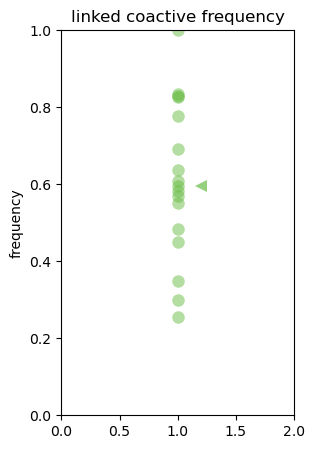

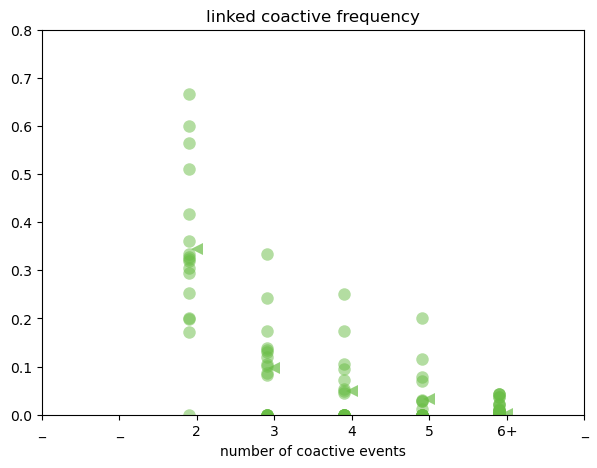

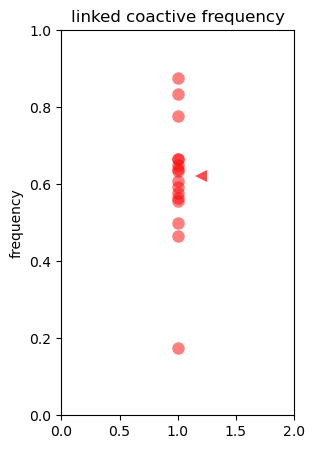

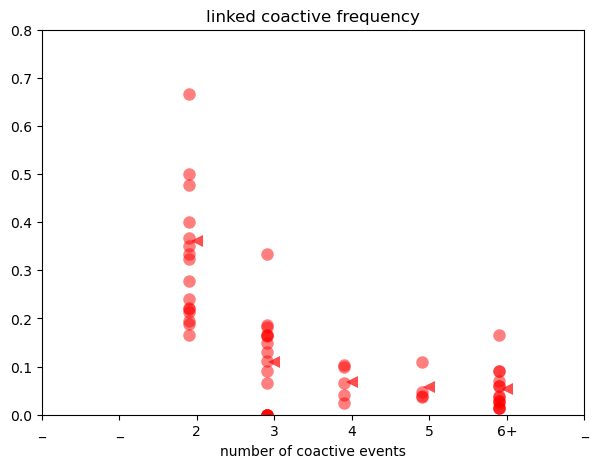

In [ ]:
plot_coactive_single(linked_unlinked_master['linked']['coactive_freqs'], '#69BD45','linked')
plot_coactive_two_plus(linked_unlinked_master['linked']['coactive_freqs'], '#69BD45','linked')
plot_coactive_single(linked_unlinked_master['linked']['rand_linked_coactive_freqs'], 'red','linked')
plot_coactive_two_plus(linked_unlinked_master['linked']['rand_linked_coactive_freqs'], 'red','linked')

print('__________________')
df = permanova_coactive_freqs(linked_unlinked_master['linked']['coactive_freqs'], linked_unlinked_master['linked']['rand_linked_coactive_freqs'])


# figure O

------------------


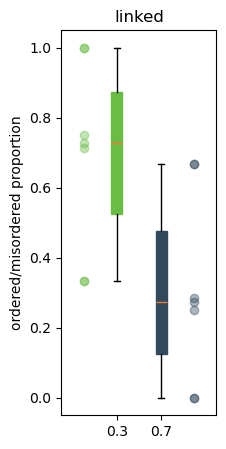

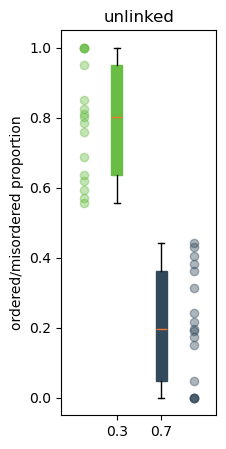

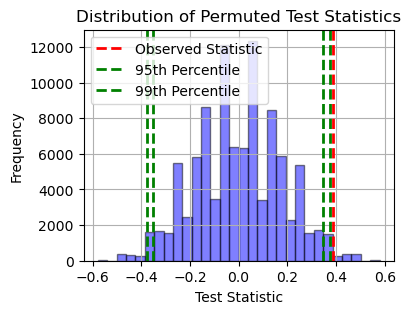

- p-value: 0.00937
- 99th percentile of permuted statistics: 0.37445887445887455
- Observed Test Statistic: 0.3880643166357452
cohens d = 1.4137352996865145
------------------


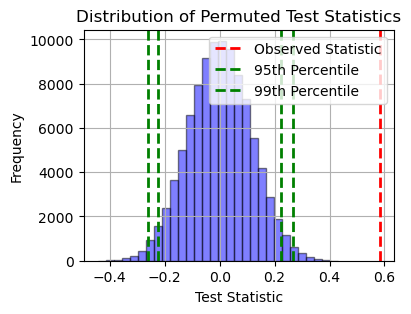

- p-value: 0.0
- 99th percentile of permuted statistics: 0.26565510616098276
- Observed Test Statistic: 0.5821773264449792
cohens d = 3.622343881937562
---------------------------------------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      24
number of groups                  2
test statistic             1.187419
p-value                       0.303
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.58287


In [128]:

plot_ordered_misrodered(linked_unlinked_master['linked']['ordered_misordered'],'linked','ordered/misordered proportion')
# SaveFig('linked_ordered_disordered.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
plot_ordered_misrodered(linked_unlinked_master['unlinked']['ordered_misordered'],'unlinked','ordered/misordered proportion')

### STATs

print('------------------')
list5 = [float(item[0]) for item in linked_unlinked_master['linked']['ordered_misordered']] 
list6 = [float(item[1]) for item in linked_unlinked_master['linked']['ordered_misordered']] 
list5= [x for x in list5 if not np.isnan(x)] 
list6= [x for x in list6 if not np.isnan(x)] 
permutation_test(list5, list6)
print(f'cohens d = {cohens_d(list5, list6)}')

print('------------------')
list7 = [float(item[0]) for item in linked_unlinked_master['unlinked']['ordered_misordered']] 
list8 = [float(item[1]) for item in linked_unlinked_master['unlinked']['ordered_misordered']] 
list7= [x for x in list7 if not np.isnan(x)] 
list8= [x for x in list8 if not np.isnan(x)] 
permutation_test(list7, list8)
print(f'cohens d = {cohens_d(list7, list8)}')


print('---------------------------------------------------')
permanova_ordered_misordered(linked_unlinked_master['linked']['ordered_misordered'], linked_unlinked_master['unlinked']['ordered_misordered'])


# figure P

------------------


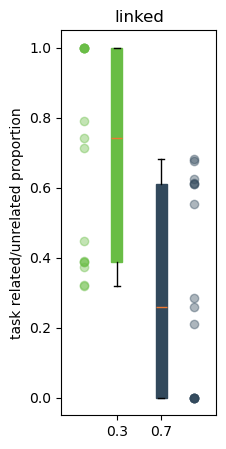

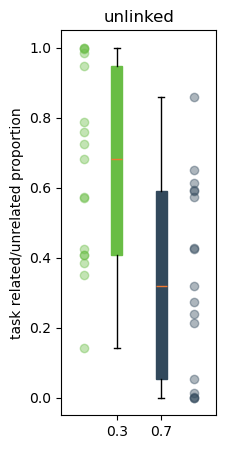

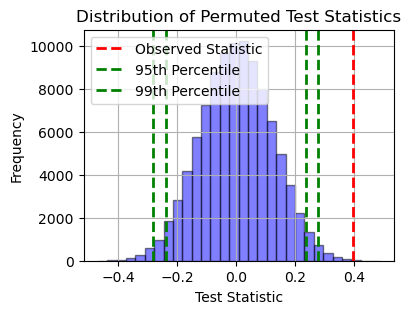

- p-value: 0.00034
- 99th percentile of permuted statistics: 0.2782906307953575
- Observed Test Statistic: 0.3969375064115581
cohens d = 1.3472485580005513
------------------


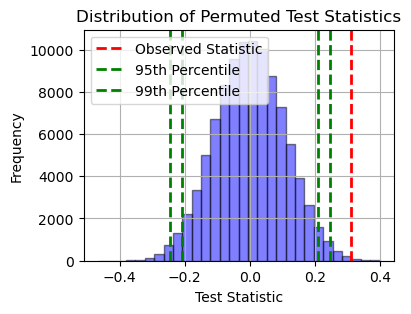

- p-value: 0.00121
- 99th percentile of permuted statistics: 0.24655674739874034
- Observed Test Statistic: 0.31177711950158005
cohens d = 1.137514476885624
---------------------------------------------------
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      34
number of groups                  2
test statistic             0.190344
p-value                       0.637
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA effect size R²: 0.61094


In [130]:
plot_ordered_misrodered(linked_unlinked_master['linked']['task_nontask'],'linked','task related/unrelated proportion')

plot_ordered_misrodered(linked_unlinked_master['unlinked']['task_nontask'],'unlinked','task related/unrelated proportion')



print('------------------')
list5 = [float(item[0]) for item in linked_unlinked_master['linked']['task_nontask']] 
list6 = [float(item[1]) for item in linked_unlinked_master['linked']['task_nontask']] 
list5= [x for x in list5 if not np.isnan(x)] 
list6= [x for x in list6 if not np.isnan(x)] 
permutation_test(list5, list6)
print(f'cohens d = {cohens_d(list5, list6)}')

print('------------------')
list7 = [float(item[0]) for item in linked_unlinked_master['unlinked']['task_nontask']] 
list8 = [float(item[1]) for item in linked_unlinked_master['unlinked']['task_nontask']] 
list7= [x for x in list7 if not np.isnan(x)] 
list8= [x for x in list8 if not np.isnan(x)] 
permutation_test(list7, list8)
print(f'cohens d = {cohens_d(list7, list8)}')

print('---------------------------------------------------')
permanova_ordered_misordered(linked_unlinked_master['linked']['task_nontask'], linked_unlinked_master['unlinked']['task_nontask'])


# figure Q

Fitted parameters: a = 0.04905225359378278, b = 2.7386562630034237
R-squared: 0.9859114510088116
p-values: [np.float64(3.418490635542781e-05), np.float64(1.0165275310392019e-07)]
Fitted parameters: a = 0.051518362579264496, b = 2.762625641144213
R-squared: 0.9888747584144898
p-values: [np.float64(1.5175370373210484e-05), np.float64(3.9329543621846597e-08)]
_________________________________________________________________________________________
                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.4435 2.0000 17.0000 10.6643 0.0010
         Pillai's trace 0.5565 2.0000 17.0000 10.6643 0.0010
 Hotelling-Lawley trace 1.2546 2.0000 17.0000 10.6643 0.0010
    Roy's greatest root 1.2546 2.0000 17.0000 10.6643 0.0010
--------------------

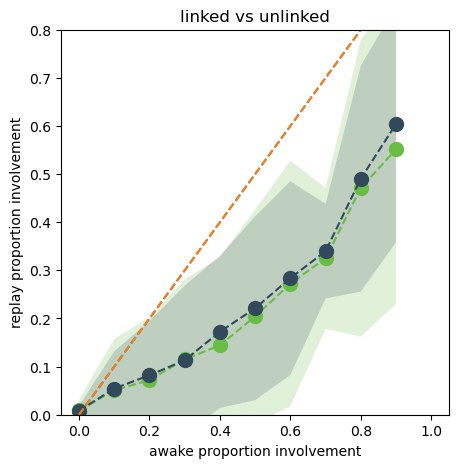

In [136]:
awake_seqbyseq_neuron_involvements = neuron_involvement_master['awake_seqbyseq_neuron_involvements']


fig, ax = plt.subplots(1, 1,figsize=(5, 5))
linked_awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(awake_seqbyseq_neuron_involvements,linked_unlinked_master['linked']['sleep_seqbyseq_neuron_involvements'])
plot_awake_sleep_relationship(linked_awake_sleep_relationship,'#69BD45',ax)
unlinked_awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(awake_seqbyseq_neuron_involvements,linked_unlinked_master['unlinked']['sleep_seqbyseq_neuron_involvements'])
plot_awake_sleep_relationship(unlinked_awake_sleep_relationship,'#32495C',ax)
ax.set_title('linked vs unlinked')

print('_________________________________________________________________________________________')
m =manova_groups_neuron_involvement(linked_awake_sleep_relationship,unlinked_awake_sleep_relationship)
eta_squared = compute_partial_eta_squared(m)
print("Partial eta-squared for each effect:", eta_squared)

